# Exploring and preparing the PertChem DB

ChemPert database contains 82,270 transcriptional signatures in response to 2566 unique chemical compounds across 167 normal cell types/lines and tissues, as well as the protein targets of 57,818 chemical compounds.

- Code: https://git-r3lab.uni.lu/menglin.zheng/chempert
- Web app: https://chempert.uni.lu/
- Paper: https://www.biorxiv.org/content/10.1101/2022.04.29.490084v1

In [1]:
from collections import defaultdict, Counter
import getpass
import sys
import time

import pandas as pd
import seaborn as sns
from tqdm import tqdm, tqdm_notebook
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib_venn import venn2
import string

In [2]:
%matplotlib inline

In [3]:
getpass.getuser()

'chloehart'

In [4]:
sys.version

'3.8.11 (default, Aug  6 2021, 08:56:27) \n[Clang 10.0.0 ]'

In [5]:
time.asctime()

'Thu Dec 15 18:42:10 2022'

In [6]:
# In order to get the data for this step download 
# Information_for_transcriptional_responses.csv from https://chempert.uni.lu/downloads
response_metdata_df = pd.read_csv(
    '../test_data/chempert/Information_for_transcriptional_responses.csv',
    usecols=[
        'Response_ID',
        'Chemical_ID',
        'Concentration',
        'Cell_Source'
    ],
    index_col='Response_ID',
)
response_metdata_df.head(4)

,Chemical_ID,Cell_Source,Concentration
Response_ID,,,
RID00001,CID01777,Hepatocyte,10uM
RID00002,CID01777,Hepatocyte,50uM
RID00003,CID01776,Hepatocyte,75uM
RID00004,CID51798,Hepatocyte,300uM


In [7]:
# In order to get the data for this step download 
#Transcriptional_responses.rds from https://chempert.uni.lu/downloads
response_df = pd.read_csv(
    '../test_data/chempert/transcriptional_responses.csv',
    dtype=str)

In [8]:
response_df['chemical'] = response_df["Response ID"].map(response_metdata_df.to_dict()['Chemical_ID'])
response_df['concentration'] = response_df["Response ID"].map(response_metdata_df.to_dict()['Concentration'])
response_df['cell_source'] = response_df["Response ID"].map(response_metdata_df.to_dict()['Cell_Source'])
response_df.head()

,Response ID,Up-regulation number,Up-regulation,Down-regulation number,Down-regulation,chemical,concentration,cell_source
0,RID00001,1,CREB3L3,0,NaN,CID01777,10uM,Hepatocyte
1,RID00002,1,MYBL1,1,LMCD1,CID01777,50uM,Hepatocyte
2,RID00003,0,NaN,4,CCNA2; HMGB2; CENPF; PTTG2,CID01776,75uM,Hepatocyte
3,RID00004,1,KLF4,7,CENPF; HMGB2; CCNA2; FOXM1; CRYM; PTTG2; ESRRG,CID51798,300uM,Hepatocyte
4,RID00005,2,CREB3L3; NR1I3,22,ID3; CCNA2; ID1; GMNN; ZNF367; CENPF; ID2; FOS...,CID51707,10000uM,Hepatocyte


## Create transcriptomics dictionary

In [9]:
upregulated_genes_dict = {chemical_id:[] for chemical_id in list(set(response_df['chemical']))}
downregulated_genes_dict = {chemical_id:[] for chemical_id in list(set(response_df['chemical']))}

#Get list of all upregulated and down regulated genes for each compound
for row in tqdm(response_df.values):
    (
        response_id,
        upregulation_count,
        upregulated_genes,
        downregulation_count,
        downregulated_genes,
        chemical_id,
        concentration,
        cell_source
    ) = row
    
    if pd.isna(concentration) or pd.isna(chemical_id):
        continue
    
    if int(upregulation_count) > 0:
        upregulated_genes_dict[chemical_id] += (upregulated_genes.split('; '))
    if int(downregulation_count) > 0:
        downregulated_genes_dict[chemical_id] += (downregulated_genes.split('; '))

#Get list of all compounds
all_chemicals = [x for x in np.unique(list(response_df['chemical'])) if x != 'nan']

#Take care of chemicals with multiple transcriptomic profiles
for chemical_id in tqdm(all_chemicals):
    
    #Get the counts for upregulated genes and downregulated genes
    upregulated_gene_counts = np.unique(upregulated_genes_dict[chemical_id], return_counts=True)
    downregulated_gene_counts = np.unique(downregulated_genes_dict[chemical_id], return_counts=True)
    placeholder = upregulated_gene_counts

    #Find genes that are upregulated and downregulated
    shared_genes = list(set(upregulated_gene_counts[0]) & set(downregulated_gene_counts[0]))
    shared_genes_index_up = [list(upregulated_gene_counts[0]).index(x) for x in shared_genes]
    shared_genes_index_down = [list(downregulated_gene_counts[0]).index(x) for x in shared_genes]
    shared_gene_counts_up = [upregulated_gene_counts[1][i] for i in shared_genes_index_up]
    shared_gene_counts_down = [downregulated_gene_counts[1][i] for i in shared_genes_index_down]
    
    #remove genes from up regulated genes that are downregulated more often
    #than up regulated and vice versa
    upregulated_genes = list(set(upregulated_gene_counts[0]) - set(shared_genes))
    downregulated_genes = list(set(downregulated_gene_counts[0]) - set(shared_genes))
    upregulated_genes += [shared_genes[i] for i in range(len(shared_genes)) if \
                             shared_gene_counts_up[i] > shared_gene_counts_down[i]*2]
    downregulated_genes += [shared_genes[i] for i in range(len(shared_genes)) if \
                             shared_gene_counts_up[i]*2 < shared_gene_counts_down[i]]
    
    # Get set of unique upregulated and downregulated genes
    upregulated_genes_dict[chemical_id] = set(upregulated_genes)
    downregulated_genes_dict[chemical_id] = set(downregulated_genes)
    
    
    
    

100%|███████████████████████████████████████| 2508/2508 [06:23<00:00,  6.53it/s]


In [10]:
transcriptomics_dict = {}

# Create transcriptomic dictionary
for row in tqdm(response_df.values):
    (
        response_id,
        upregulation_count,
        upregulated_genes,
        downregulation_count,
        downregulated_genes,
        chemical_id,
        concentration,
        cell_source
    ) = row

    # Check if row has a chemical_id and concentration
    if pd.isna(concentration) or pd.isna(chemical_id):
        continue
     
    # Add chemical to dictionary if it is not already a key
    if chemical_id not in transcriptomics_dict:
        transcriptomics_dict[chemical_id] = {}
        
    # Add cell source
    if cell_source not in transcriptomics_dict[chemical_id]:
        transcriptomics_dict[chemical_id][cell_source] = defaultdict(str)
    
    # Add upregulated genes
    if int(upregulation_count) > 0:
        for ugene in upregulated_genes.split('; '):
            
            if pd.isna(ugene) or len(ugene) < 3:
                continue
                
            # Skip non human genes
            if not ugene[0].isupper() or not ugene[1].isupper():
                continue
                
            if ugene not in upregulated_genes_dict[chemical_id]:
                continue
            
            transcriptomics_dict[chemical_id][cell_source][ugene] = '1'
    
    # Add downregulated genes
    if int(downregulation_count) > 0:
        for dgene in downregulated_genes.split('; '):
            
            if pd.isna(dgene) or len(dgene) < 3:
                continue
            
            # Skip non human genes
            if not dgene[0].isupper() or not dgene[1].isupper():
                continue
            
            if dgene not in downregulated_genes_dict[chemical_id]:
                continue
            
            transcriptomics_dict[chemical_id][cell_source][dgene] = '-1'


100%|███████████████████████████████████| 82270/82270 [00:09<00:00, 8351.55it/s]


# Create transcriptomic cell line dictionary

In [12]:
#Create dictionaries
upregulated_genes_dict_cell_source = {chemical_id:{} for chemical_id in list(set(response_df['chemical']))}
downregulated_genes_dict_cell_source = {chemical_id:{} for chemical_id in list(set(response_df['chemical']))}

#Create dictionary of upregulated and downregulated genes for 
#each drug accounting for cell line
for row in tqdm(response_df.values):
    (
        response_id,
        upregulation_count,
        upregulated_genes,
        downregulation_count,
        downregulated_genes,
        chemical_id,
        concentration,
        cell_source
    ) = row
    
    if pd.isna(concentration) or pd.isna(chemical_id):
        continue
        
    if cell_source not in upregulated_genes_dict_cell_source[chemical_id].keys():
        upregulated_genes_dict_cell_source[chemical_id][cell_source] = []
    
    if cell_source not in downregulated_genes_dict_cell_source[chemical_id].keys():
        downregulated_genes_dict_cell_source[chemical_id][cell_source] = []
    
    if int(upregulation_count) > 0:
        upregulated_genes_dict_cell_source[chemical_id][cell_source] += (upregulated_genes.split('; '))
    if int(downregulation_count) > 0:
        downregulated_genes_dict_cell_source[chemical_id][cell_source] += (downregulated_genes.split('; '))
        
#Take care of chemicals with multiple transcriptomic profiles
for chemical_id in tqdm(all_chemicals):

    current_cell_sources = set(upregulated_genes_dict_cell_source[chemical_id].keys())\
                            .union(set(downregulated_genes_dict_cell_source[chemical_id].keys()))
    for cell_source in current_cell_sources:
        
        #Get the counts for upregulated genes and downregulated genes
        upregulated_gene_counts = np.unique(upregulated_genes_dict_cell_source[chemical_id][cell_source]\
                                            , return_counts=True)
        downregulated_gene_counts = np.unique(downregulated_genes_dict_cell_source[chemical_id][cell_source]\
                                              , return_counts=True)

        #Find genes that are upregulated and downregulated
        shared_genes = list(set(upregulated_gene_counts[0]) & set(downregulated_gene_counts[0]))
        shared_genes_index_up = [list(upregulated_gene_counts[0]).index(x) for x in shared_genes]
        shared_genes_index_down = [list(downregulated_gene_counts[0]).index(x) for x in shared_genes]
        shared_gene_counts_up = [upregulated_gene_counts[1][i] for i in shared_genes_index_up]
        shared_gene_counts_down = [downregulated_gene_counts[1][i] for i in shared_genes_index_down]

        #remove genes from up regulated genes that are downregulated more often
        #and vice versa
        upregulated_genes = list(set(upregulated_gene_counts[0]) - set(shared_genes))
        downregulated_genes = list(set(downregulated_gene_counts[0]) - set(shared_genes))
        upregulated_genes += [shared_genes[i] for i in range(len(shared_genes)) if \
                                 shared_gene_counts_up[i] > shared_gene_counts_down[i]*2]
        downregulated_genes += [shared_genes[i] for i in range(len(shared_genes)) if \
                                 shared_gene_counts_up[i]*2 < shared_gene_counts_down[i]]

        upregulated_genes_dict_cell_source[chemical_id][cell_source] = set(upregulated_genes)
        downregulated_genes_dict_cell_source[chemical_id][cell_source] = set(downregulated_genes)
    

100%|███████████████████████████████████████| 2508/2508 [04:15<00:00,  9.82it/s]


In [13]:
transcriptomics_cell_source_dict = {}

# Create transcriptomic cell line dictionary
for row in tqdm(response_df.values):
    (
        response_id,
        upregulation_count,
        upregulated_genes,
        downregulation_count,
        downregulated_genes,
        chemical_id,
        concentration,
        cell_source
    ) = row

    # Check if row has a concentration and chemical_id
    if pd.isna(concentration) or pd.isna(chemical_id):
        continue
        
    # Add chemical_id to the dict if it is not already a key
    if chemical_id not in transcriptomics_cell_source_dict:
        transcriptomics_cell_source_dict[chemical_id] = {}
       
    # Add cell source
    if cell_source not in transcriptomics_cell_source_dict[chemical_id]:
        transcriptomics_cell_source_dict[chemical_id][cell_source] = defaultdict(str)
    
    # Add upregulated genes
    if int(upregulation_count) > 0:
        for ugene in upregulated_genes.split('; '):
            
            if pd.isna(ugene) or len(ugene) < 3:
                continue
                
            # Skip non human genes
            if not ugene[0].isupper() or not ugene[1].isupper():
                continue
                
            if ugene not in upregulated_genes_dict_cell_source[chemical_id][cell_source]:
                continue
            
            transcriptomics_cell_source_dict[chemical_id][cell_source][ugene] = '1'
    
    # Add downregulated genes
    if int(downregulation_count) > 0:
        for dgene in downregulated_genes.split('; '):
            
            if pd.isna(dgene) or len(dgene) < 3:
                continue
            
            # Skip non human genes
            if not dgene[0].isupper() or not dgene[1].isupper():
                continue
            
            if dgene not in downregulated_genes_dict_cell_source[chemical_id][cell_source]:
                continue
            transcriptomics_cell_source_dict[chemical_id][cell_source][dgene] = '-1'


100%|███████████████████████████████████| 82270/82270 [00:09<00:00, 8385.90it/s]


In [15]:
# In order to get the data for this step download 
# Targets_of_perturbagens.rds from https://chempert.uni.lu/downloads
drug_target_df = pd.read_csv(
    '../test_data/chempert/targets_of_perturbagens.csv',
    dtype=str
)

# Remove unknown drug-target effects
drug_target_df = drug_target_df[drug_target_df['Effect'] != '2'] 

# Create target dictionary

In [17]:
target_dict = {}

# Create target dictionary
for row in tqdm(drug_target_df.values):
    (
        chemical_id,
        chemical_name,
        target,
        effect,
        source
    ) = row
    
    # Check if effect and chemical_id are in the row
    if pd.isna(effect) or pd.isna(chemical_id):
        continue
    
    # Check length of target name
    if len(target) < 3:
        continue
        
    # Skip non human genes
    if not target[0].isupper() or not target[1].isupper():
        continue
    
    # Add chemical to target dictionary
    if chemical_id not in target_dict:
        target_dict[chemical_id] = defaultdict(str)
        
    target_dict[chemical_id][target] = effect 

100%|█████████████████████████████████| 36050/36050 [00:00<00:00, 331089.63it/s]


In [18]:
chemicals_to_correlate = set(
    transcriptomics_dict.keys()
).intersection(
    target_dict.keys()
)

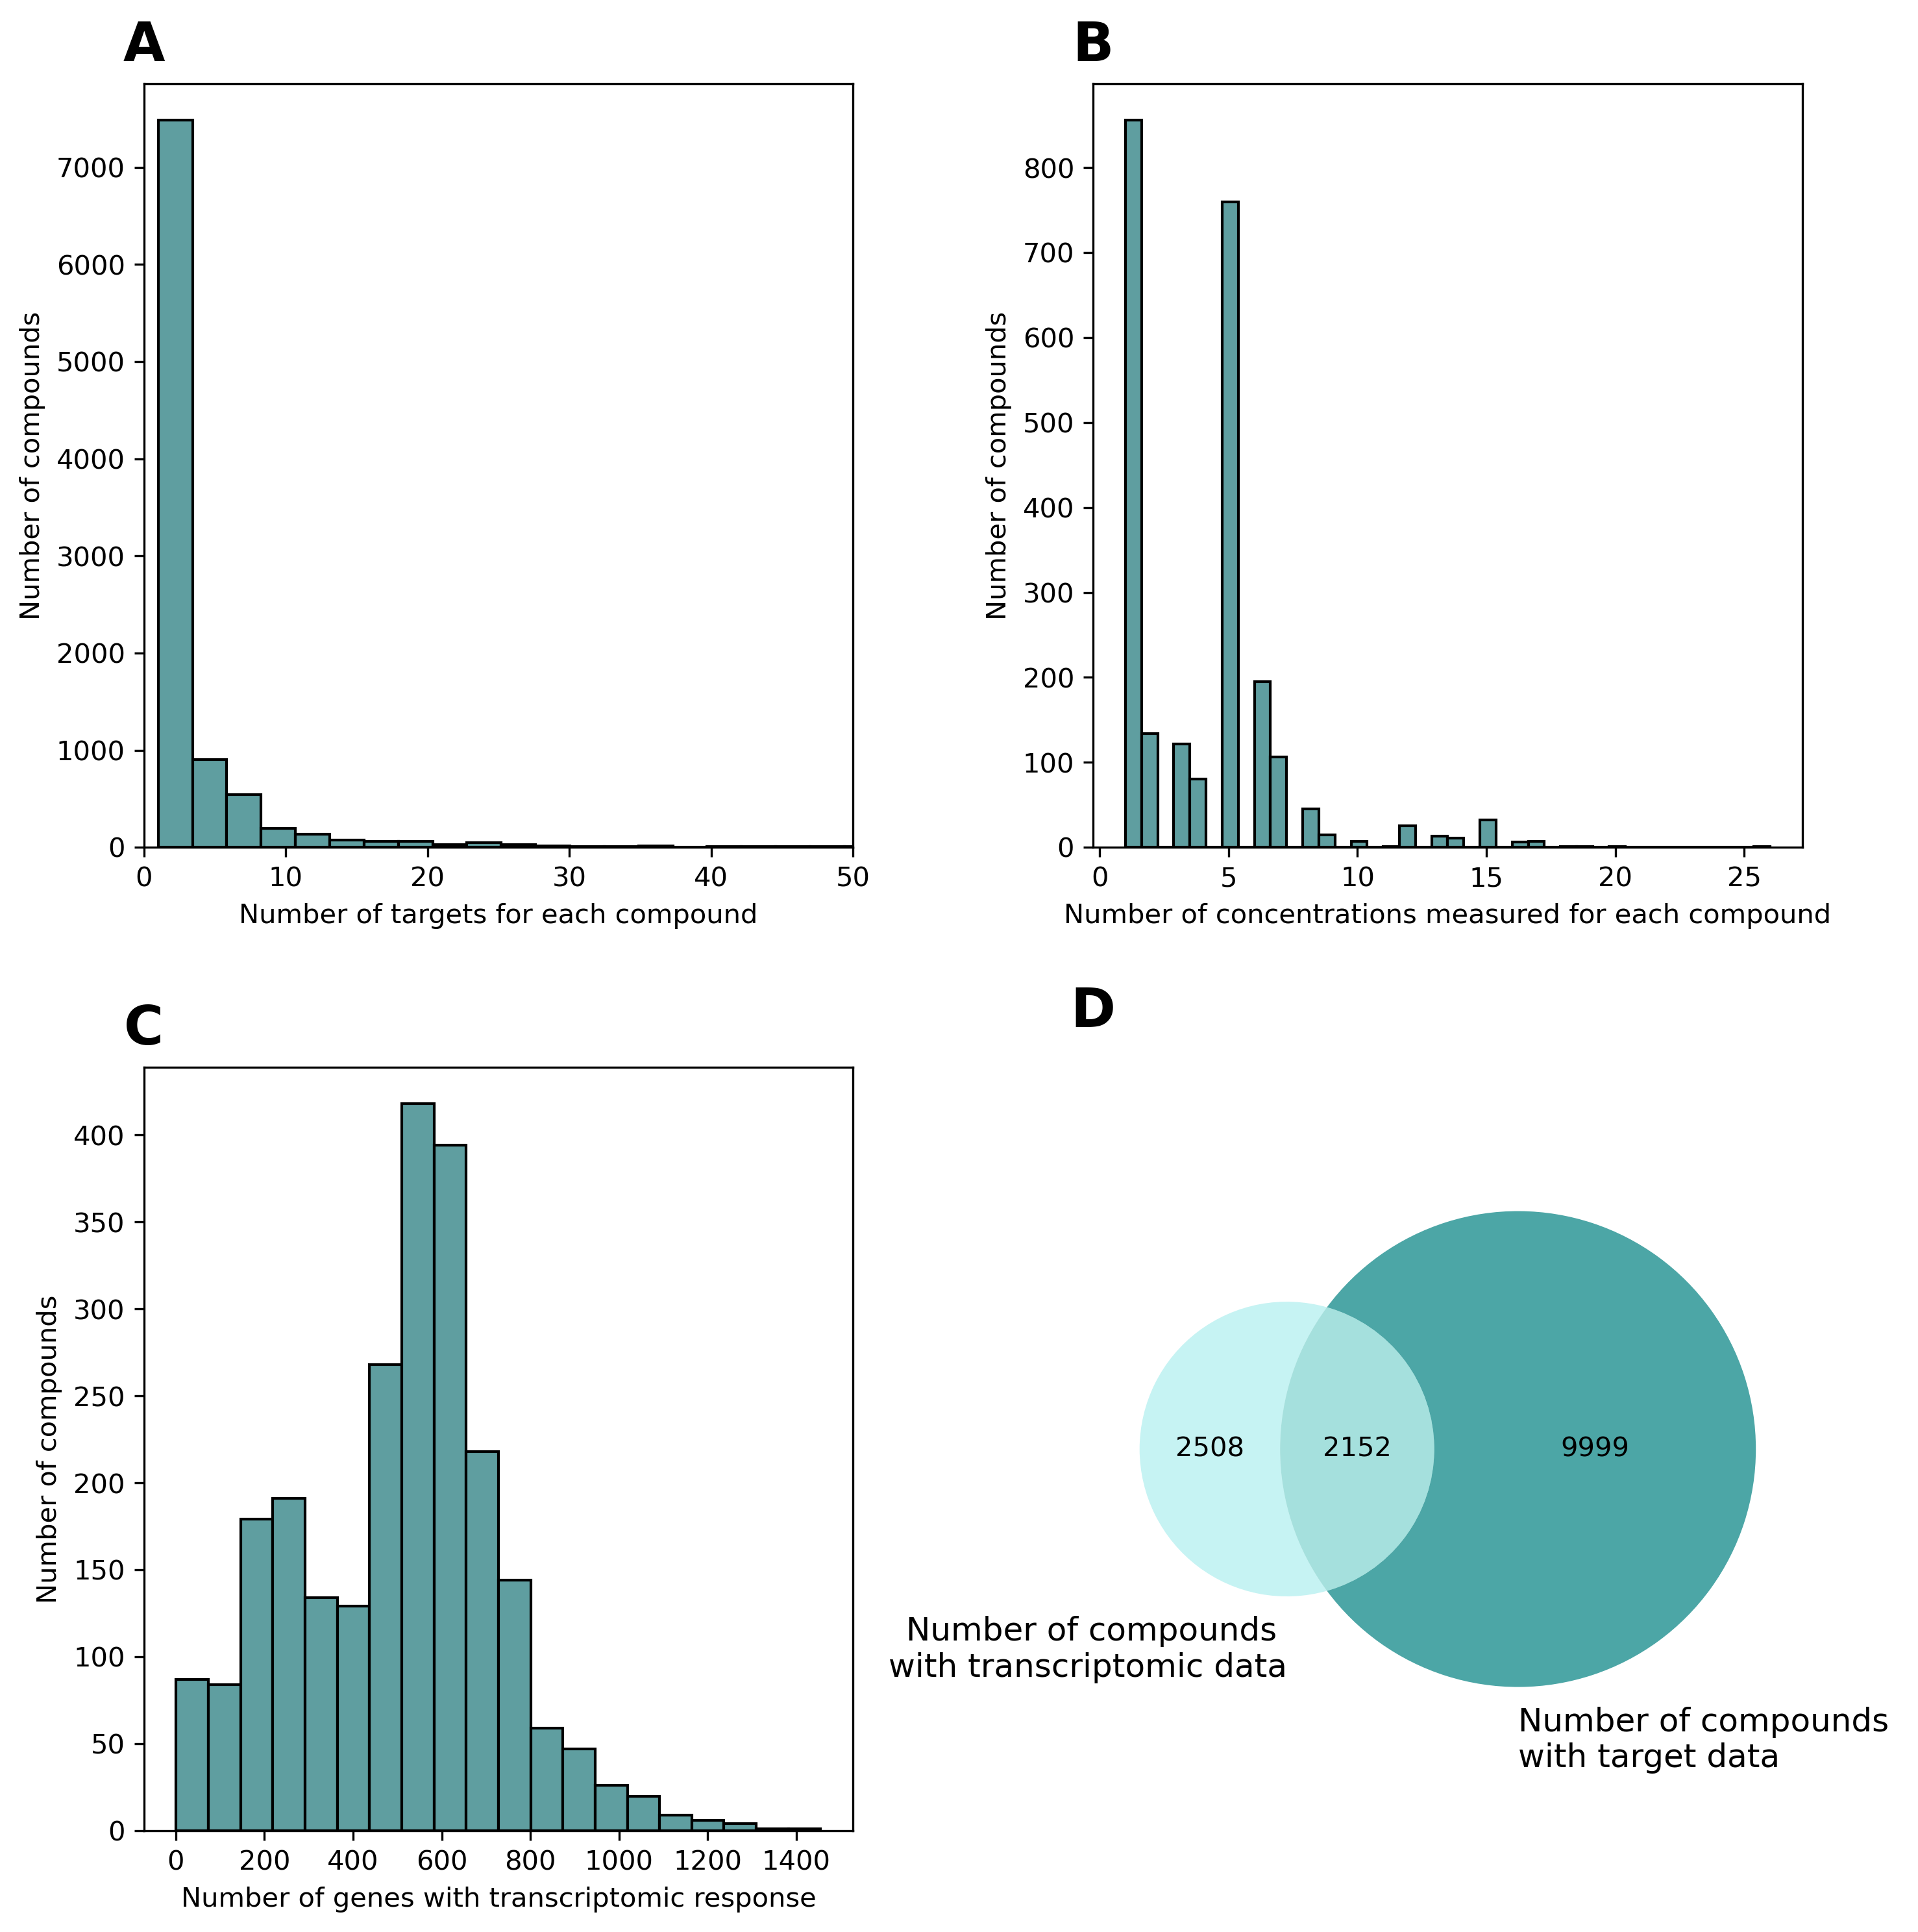

In [19]:
#Create venn diagram of number of chemicals in target_dict and transcriptomics_dict
plt.figure(dpi=300, figsize=([10,10]))

#Get number of targets for each compound
target_counter = {compound: len(target_dict[compound]) for compound in target_dict.keys()}
regulated_counter = {compound:len(set.union(*[set(transcriptomics_dict[compound][cell_type]) 
                                              for cell_type in transcriptomics_dict[compound].keys()])) 
                     for compound in transcriptomics_dict.keys()}

# Create plot A
plt.subplot(2,2,1)
plt.hist(target_counter.values(), bins=100, ec='black', color='cadetblue')
plt.xlabel('Number of targets for each compound')
plt.ylabel('Number of compounds')
plt.xlim(0,50) # Note that x limit has been applied
plt.text(0, 1.05, string.ascii_uppercase[0],  
        size=20, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)

# Create plot B
plt.subplot(2,2,2)
plt.hist([
    len(concentrations)
    for chemical, concentrations in transcriptomics_dict.items()
], bins=40, ec='black', color='cadetblue')
plt.xlabel('Number of concentrations measured for each compound')
plt.ylabel('Number of compounds')
plt.text(0, 1.05, string.ascii_uppercase[1],  
        size=20, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)

# Create plot C
plt.subplot(2,2,3)
plt.hist(regulated_counter.values(), bins=20, ec='black', color='cadetblue')
plt.ylabel('Number of compounds')
plt.xlabel('Number of genes with transcriptomic response')
plt.text(0, 1.05, string.ascii_uppercase[2],  
        size=20, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)

# Get numbers for venn diagram
num_transcriptomic = len(set([x for x in response_metdata_df['Chemical_ID'] if not pd.isna(x)])) 
num_target = len(set([x for x in drug_target_df['Chemical ID'] if not pd.isna(x)]))

# Create plot D
plt.subplot(2,2,4)
c = venn2(subsets = (num_transcriptomic, num_target, 
                     len(chemicals_to_correlate)), 
                    set_labels = ('Number of compounds \nwith transcriptomic data', 
                                  'Number of compounds \nwith target data'), 
                    set_colors=('paleturquoise', 'teal'), alpha=.7)
c.get_patch_by_id('11').set_color('lightseagreen')
c.get_patch_by_id('11').set_edgecolor('none')
c.get_patch_by_id('11').set_alpha(0.4)
plt.text(0, 1.27, string.ascii_uppercase[3],  
        size=20, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)

plt.tight_layout()
plt.savefig('../figures/figure_2.png', bbox_inches='tight')
plt.show()

## Prepare vectors for each drug

In [26]:
gene_counter_targets = Counter([
    str(gene)
    for gene_dict in target_dict.values()
    for gene in gene_dict
])

gene_counter_transcriptomics = Counter([
    str(gene)
    for gene_dict in transcriptomics_dict.values()
    for concentration_dict in gene_dict.values()
    for gene in concentration_dict
])

In [27]:
# All genes sorted to export the vectors for each drug in the same order
# 1. One vector for each chemical with the targets 
# 2. One vector for each chemical with the transcriptional response 

#### Example ####

# targets -> [0,0,0,0,0,0,1,0,0,0,0,0,...] 
# response -> [0,0,1,0,1,1,0,-1,0,0,0,0,...]

columns_genes = sorted(
    list(set(gene_counter_targets.keys()).union(set(gene_counter_transcriptomics.keys())))
)

In [23]:
# Get all chemicals
all_chemicals = [chemical
        for chemical in transcriptomics_dict.keys()
        if chemical in chemicals_to_correlate]
   
# Get cell lines for each chemical
cell_lines = {}
for chemical in tqdm(all_chemicals):  
    current_df = response_metdata_df.loc[response_metdata_df['Chemical_ID'].apply(lambda x: x==chemical)]
    cell_lines[chemical] = np.unique(list(current_df['Cell_Source']))
    
# Get cell_line names
chemical_cell_line_names = []
for chemical in tqdm_notebook(all_chemicals):
    for cell_line in cell_lines[chemical]:
        chemical_cell_line_names.append(chemical + '_' + cell_line)
        

100%|██████████████████████████████████████| 2152/2152 [00:19<00:00, 109.06it/s]
/var/folders/3z/y7y2jb494531f1sq7lhdbnt40000gn/T/ipykernel_56312/1415953993.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for chemical in tqdm_notebook(all_chemicals):


  0%|          | 0/2152 [00:00<?, ?it/s]

In [28]:
transcriptional_response_cell_lines_df = pd.DataFrame(
    index=sorted(chemical_cell_line_names),
    columns=columns_genes, # Genes
)

transcriptional_response_vectors_df = pd.DataFrame(
    #Chemicals as rows
    index=sorted([
        chemical
        for chemical in target_dict.keys()
        if chemical in chemicals_to_correlate
    ]),
    columns=columns_genes, # Genes
)

target_vectors_df = pd.DataFrame(
    # Chemicals as rows
    index=sorted([
        chemical
        for chemical in target_dict.keys()
        if chemical in chemicals_to_correlate
    ]),
    columns=columns_genes, # Genes
)

In [29]:
assert target_vectors_df.shape[0] == transcriptional_response_vectors_df.shape[0], 'matrices do not match'
assert target_vectors_df.shape[1] == transcriptional_response_vectors_df.shape[1], 'vectors do not match'

In [30]:
#Populate vector dataframes and ensure data quality
for chemical in tqdm(sorted([
        chemical
        for chemical in transcriptomics_dict.keys()
        if chemical in chemicals_to_correlate
    ])):
    
    
    
    # Iterate through the genes and fill the row    
    for gene, effect in target_dict[chemical].items():
        # Ensure the effect is an integer and there are no weird characters
        if effect not in {'1', '-1', 1, -1}:
            print(f'{effect} not allowed')
            continue
            
        target_vectors_df.loc[chemical, gene] = int(effect)

#Populate transcriptomic vector dataframe with cell line information
cell_sources = []

for chemical, cell_source_dict in tqdm(transcriptomics_cell_source_dict.items()):
                              
    if chemical not in chemicals_to_correlate:
        continue
    
    for cell_source, gene_dict in cell_source_dict.items():
        
        # Keep track of the concentrations to check them later
        cell_sources.append(cell_source)
        
        for gene, effect in gene_dict.items():
            # Ensure the effect is an integer and there are no weird characters
            if effect not in {'1', '-1', 1, -1}:
                print(f'{effect} not allowed')
                continue

            transcriptional_response_cell_lines_df.loc[chemical + '_' + cell_source, gene] = int(effect)

#Populate transcriptomic vector dataframe with cell line information
for chemical, cell_source_dict in tqdm(transcriptomics_dict.items()):
                              
    if chemical not in chemicals_to_correlate:
        continue
    
    for cell_source, gene_dict in cell_source_dict.items():
        
        # Keep track of the concentrations to check them later
        
        for gene, effect in gene_dict.items():
            # Ensure the effect is an integer and there are no weird characters
            if effect not in {'1', '-1', 1, -1}:
                print(f'{effect} not allowed')
                continue

            transcriptional_response_vectors_df.loc[chemical, gene] = int(effect)


100%|███████████████████████████████████████| 2419/2419 [00:47<00:00, 51.15it/s]


In [31]:
# Percentage of genes that were not effected
transcriptional_response_vectors_df.isna().sum().sum() / (
    transcriptional_response_vectors_df.shape[0] * transcriptional_response_vectors_df.shape[1]
) * 100

89.6589644679528

In [32]:
# Percentage of genes that were not targeted
target_vectors_df.isna().sum().sum() / (
    target_vectors_df.shape[0] * target_vectors_df.shape[1]
) * 100

99.90471060480817

In [33]:
# Fill nan values with 0
transcriptional_response_vectors_df.fillna(0, inplace=True)
transcriptional_response_cell_lines_df.fillna(0, inplace=True)
target_vectors_df.fillna(0, inplace=True)

In [34]:
transcriptional_response_vectors_df.head(3)

,AAAS,AADAC,AADACL2,AADAT,AASS,AATF,ABAT,ABCA1,ABCB1,ABCB11,...,ZSCAN32,ZSCAN4,ZSCAN5A,ZSCAN5B,ZSCAN5DP,ZSCAN9,ZXDA,ZXDB,ZXDC,ZZZ3
CID00001,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,-1,0,0,0,-1
CID00002,0,0,0,0,0,-1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,-1
CID00006,0,0,0,0,0,-1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,-1


In [35]:
target_vectors_df.head(3)

,AAAS,AADAC,AADACL2,AADAT,AASS,AATF,ABAT,ABCA1,ABCB1,ABCB11,...,ZSCAN32,ZSCAN4,ZSCAN5A,ZSCAN5B,ZSCAN5DP,ZSCAN9,ZXDA,ZXDB,ZXDC,ZZZ3
CID00001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CID00002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CID00006,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
transcriptional_response_cell_lines_df.head(3)

,AAAS,AADAC,AADACL2,AADAT,AASS,AATF,ABAT,ABCA1,ABCB1,ABCB11,...,ZSCAN32,ZSCAN4,ZSCAN5A,ZSCAN5B,ZSCAN5DP,ZSCAN9,ZXDA,ZXDB,ZXDC,ZZZ3
CID00001_HA1E,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,-1,0,0,0,-1
CID00002_FIBRNPC,0,0,0,0,0,-1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,-1
CID00002_NEU,0,0,0,0,0,-1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [29]:
transcriptional_response_cell_lines_df.to_csv(
    '../data/Transcriptional_data_frames/transcriptional_response_vectors_cell_line.tsv', 
    sep='\t',
)

transcriptional_response_vectors_df.to_csv(
    '../data/Transcriptional_data_frames/transcriptional_response_vectors.tsv', 
    sep='\t',
)

target_vectors_df.to_csv(
    '../data/target_data_frames/target_vectors_ChemPert.tsv', 
    sep='\t',
)

# Get gene expression for known targets

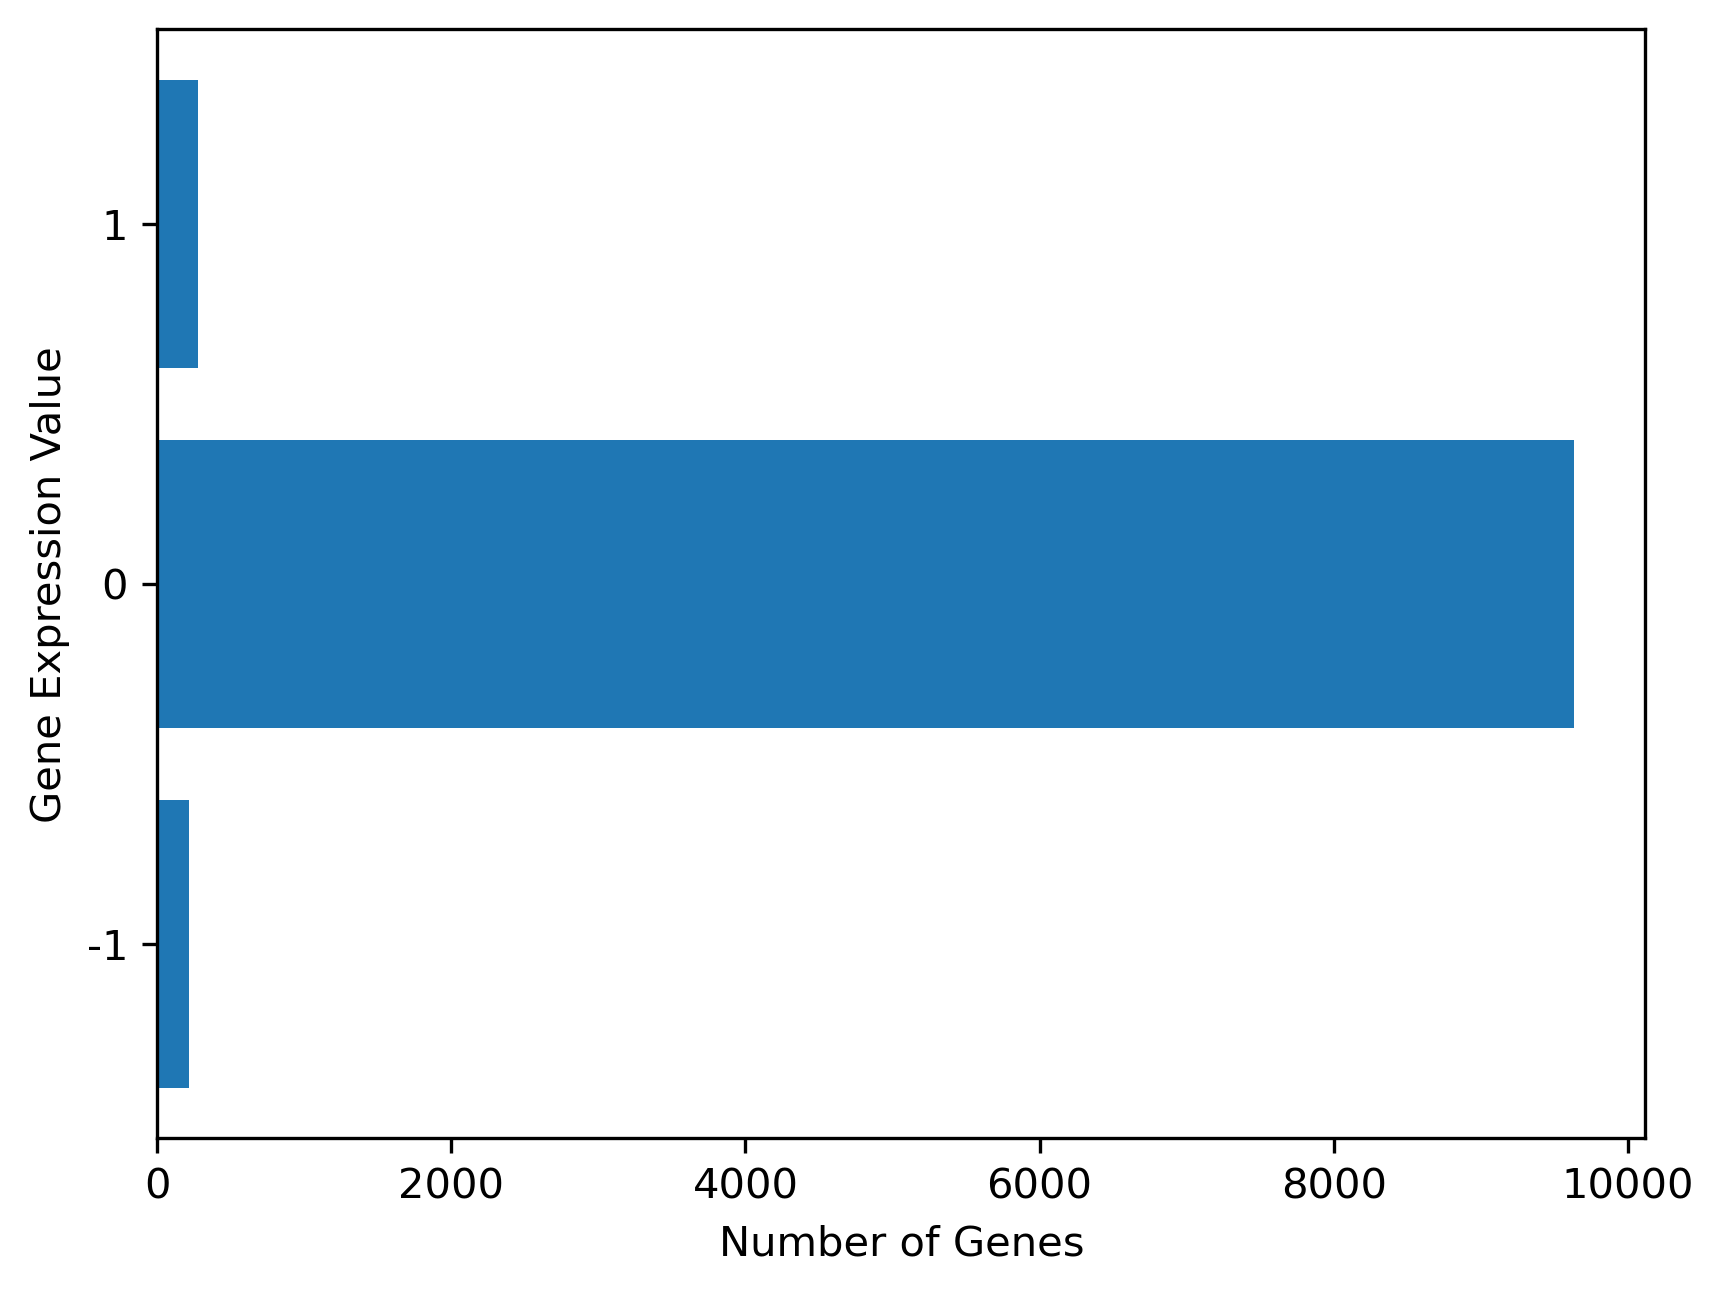

In [37]:
# Set initial variables
target_values = []
plt.figure(dpi=300)

# Get gene expression values
for drug in target_vectors_df.index.values:
    targets = np.nonzero(list(target_vectors_df.loc[drug]))[0]
    target_names = [target_vectors_df.columns[i] for i in targets]
    target_values = target_values + [transcriptional_response_vectors_df.loc[drug, gene] for gene in target_names]

# Create plot
counts = np.unique(target_values, return_counts=True)
plt.barh(['-1','0','1'], counts[1])
plt.ylabel('Gene Expression Value')
plt.xlabel("Number of Genes")
plt.savefig('../figures/Supplementary_figure_1.png')
plt.show()